In [120]:
import os
import git
from pathlib import Path
from typing import List
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
import scipy
import pylustrator
import math

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = False

os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "results", "combined_results"))
np.random.seed(0)
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "draft_plots")

def variance_prior(r, eta, scale=1):
    beta = (eta+1.5)/r
    var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
    return var_prior

def kurtosis_prior(r, eta, fisher=True):
    beta = (eta+1.5)/r
    kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2 
    if fisher:
        return kurtosis - 3
    else:
        return kurtosis 

fixed_palette = {
    'gray': 'xkcd:gray',
    'green': 'xkcd:shamrock green',
    'red': 'xkcd:light red',
    'blue': 'xkcd:blue',
}

def find_master_dfs(root_dir: str) -> List[str]:
    root_path = Path(root_dir)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    master_df_paths = []
    for current_dir, _, files in os.walk(root_path):
        if 'master_df.csv' in files:
            master_df_path = Path(os.path.join(current_dir, 'master_df.csv'))
            master_df_paths.append(str(master_df_path.absolute()))
    return master_df_paths

def add_hull(master_df, rEtaKsstats_dict, GROUP='group', debug=False):

    master_df_copy = master_df.copy()
    master_df_copy = master_df.set_index(GROUP)
    groups = master_df_copy.index
    master_df_copy["hull"] = ""

    for group in groups:
        if master_df_copy.loc[group, "total_samples"] < 10:
            master_df_copy.loc[group, "hull"] = np.nan
           
        else:
            drop_keys =list(rEtaKsstats_dict[group].keys())[-3:]
            if debug:
                print(drop_keys)
            pre_optimization = pd.DataFrame(rEtaKsstats_dict[group]).drop(drop_keys, axis = 1 )
            optimization = pd.DataFrame(rEtaKsstats_dict[group])[drop_keys]
            optimization = optimization.rename(columns = {"r_optimize": "r", "eta_optimize": "eta", drop_keys[-1]: "ksstat"})
            optimization = optimization.dropna()
            full_df = pre_optimization.merge(optimization, on=["r", "eta"], how="outer")
            full_df = full_df.set_index(["r", "eta"])
            full_df["ksstat"] = full_df.min(axis=1)
            full_df = full_df.reset_index()
            full_df = full_df[["r", "eta", "ksstat"]]
            full_df["1/beta"] = full_df["r"]/(full_df["eta"] + 1.5)
            MULT = 1.2
            cutoff = max(min(full_df["ksstat"]) * MULT, master_df_copy.loc[group, "kstest_stat_cutoff_0.05"], 0.01)
            filtered_df = full_df[full_df["ksstat"] < cutoff]
            points = np.column_stack((filtered_df["r"], filtered_df["1/beta"])) + stats.norm.rvs(size=(len(filtered_df), 2)) * 0.001  # Adding small noise for convex hull computation
            hull = ConvexHull(points)
            master_df_copy.loc[group, "hull"] = hull

    return master_df_copy.reset_index()

relevant_cols = ['group', 'obs_var', 'var_lower', 'var_upper', 'obs_kurt', 'kurt_lower',
       'kurt_upper', 'total_samples', 'initial_r', 'initial_eta', # 'initial_scale',
       'kstest_stat_initial', 'kstest_stat_cutoff_0.05',
       'best_r', 'best_eta', # 'best_scale', 
       'kstest_stat_best', # 'n_pval_0.05',
        'param_gaussian',
       'kstest_stat_gaussian', 'kstest_pval_gaussian', 'param_laplace',
       'kstest_stat_laplace', 'kstest_pval_laplace', 'param_t',
       'kstest_stat_t', 'kstest_pval_t', 'kstest_pval_gengamma', 
       'dataset', 'subset', 'transform', 'orientation', 'channel', 'github_plot', 'dataset_type', 'hull']

all_paths = find_master_dfs(os.path.join(ROOT_DIR, "results", "case-studies"))
all_master_dfs = []
github_plots_path = "https://github.com/yashdave003/hierarchical-bayesian-model-validation/blob/main/results/case-studies/"

for path in all_paths:
    if 'scaleTesting' in path:
        continue
    master_df = pd.read_csv(path)
    master_df = master_df.rename(columns={master_df.columns[0]: 'group'})
    parts = Path(path).parts[-7:]
    if parts[0] == 'case-studies':
        parts = parts[1:]
    if "MRI" in path:
        dataset, slice, transform, orientation, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = slice
        master_df['channel'] = np.nan
        master_df['orientation'] = orientation
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, slice, transform, orientation, 'plots', f'compare_cdf_pdf_layer_{group}.jpg']) for group in master_df['group']]
    
    elif len(parts) > 6:
        dataset, subset, transform, orientation, channel, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = subset
        master_df['channel'] = channel
        master_df['orientation'] = orientation
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, subset, transform, orientation, channel, 'plots', f'compare_cdf_pdf_layer_{group}.jpg']) for group in master_df['group']]
    else:
        dataset, size, transform, channel, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = size
        master_df['channel'] = channel
        master_df['orientation'] = np.nan
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, size, transform, channel, 'plots', f'compare_cdf_pdf_layer_{group}.jpg']) for group in master_df['group']]
    
    if dataset in ['pastis', 'agriVision', 'spaceNet']:
        master_df['dataset_type'] = 'remote sensing'
    elif dataset in ['syntheticMRI2D', 'syntheticMRI3D']:
        master_df['dataset_type'] = 'medical'
    elif dataset in ['coco', 'segmentAnything']:
        master_df['dataset_type'] = 'natural'

    GROUP = 'layer' if transform.split("-")[0] == 'wavelet' else ('band' if transform.split("-")[0] == 'fourier' else 'error')
    rEtaKsstatsDict = pd.read_pickle(path[:-18] + "cache/rEtaKsstats_dict.pickle")
    master_df = add_hull(master_df, rEtaKsstatsDict)


    all_master_dfs.append(master_df[relevant_cols])
    
main_df = pd.concat(all_master_dfs)
# main_df['prior_var'] = main_df.apply(lambda row : variance_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
# main_df['prior_kurt'] = main_df.apply(lambda row : kurtosis_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
# main_df['gaussian_kurt'] = np.zeros(main_df.shape[0])
# main_df['laplace_kurt'] = 3*np.ones(main_df.shape[0])
main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r'] 
main_df['best_1/beta'] = 1/main_df['best_beta']
main_df['total_samples'] = main_df['total_samples']//10 # TODO: look into why total_samples*10
main_df['kstest_stat_cutoff_0.10'] = stats.kstwo(n=main_df['total_samples']).isf(0.1)
kstest_stat_cutoff_2 = 0.2
kstest_stat_cutoff_2_name = 'kstest_stat_cutoff_0.20'
main_df[kstest_stat_cutoff_2_name] = stats.kstwo(n=main_df['total_samples']).isf(kstest_stat_cutoff_2)
main_df['beat_all_priors'] = (main_df['kstest_stat_best'] < np.minimum.reduce([main_df['kstest_stat_gaussian'], main_df['kstest_stat_laplace'], main_df['kstest_stat_t']])).astype(int)


frequency_map = pd.read_csv(os.path.join(ROOT_DIR, "transformed-data", "master-frequency-map.csv")).set_index(['dataset', 'transform', 'group'])
# main_df = main_df.set_index(['dataset', 'subset', 'transform', 'group']).merge(frequency_map, left_index = True, right_index=True).reset_index()
main_df = main_df.set_index(['dataset', 'subset', 'transform', 'group']).reset_index() #[(main_df['dataset'] == 'pastis') | (main_df['dataset'] == 'agriVision') | (main_df['dataset'] == 'spaceNet')]
print(main_df.shape)
main_df = main_df.merge(pd.read_csv('result_categorization - combined_categories.csv')[['github_plot', 'failure_category', 'failure_type', 'which_ones']], on='github_plot', how='left')
main_df['dataset'].value_counts()
main_df.head()

/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:269: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),
/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:269: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),


(725, 38)


,dataset,subset,transform,group,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,...,dataset_type,hull,best_beta,best_1/beta,kstest_stat_cutoff_0.10,kstest_stat_cutoff_0.20,beat_all_priors,failure_category,failure_type,which_ones
0,syntheticMRI3D,full,wavelet,2,NaN,NaN,NaN,NaN,NaN,NaN,...,medical,NaN,NaN,NaN,NaN,NaN,0,trivial_failure,low samples,NaN
1,syntheticMRI3D,full,wavelet,3,1917588.40,1678674.100,2165048.500,-0.628360,-0.869535,-0.348175,...,medical,<scipy.spatial._qhull.ConvexHull object at 0x7...,21.078431,0.047442,0.160438,0.140370,0,trivial_failure,multimodal,NaN
2,syntheticMRI3D,full,wavelet,4,814282.00,777582.600,851497.500,1.116847,0.878992,1.405564,...,medical,<scipy.spatial._qhull.ConvexHull object at 0x7...,3.333333,0.300000,0.025709,0.022526,0,interesting_failure,double inflection,NaN
3,syntheticMRI3D,full,wavelet,5,249365.95,231914.970,267766.940,5.788045,4.961286,6.675331,...,medical,<scipy.spatial._qhull.ConvexHull object at 0x7...,73.000000,0.013699,0.007099,0.006222,1,practically_pass,pass,NaN
4,syntheticMRI3D,full,wavelet,6,43869.16,40573.156,47332.902,6.932356,5.826878,8.281218,...,medical,<scipy.spatial._qhull.ConvexHull object at 0x7...,10.000000,0.100000,0.002280,0.001998,1,practically_pass,pass,NaN


# ROI

In [121]:
r_shade_roi = np.linspace(0.01, 4, 100)
eta_shade_roi = np.linspace(-0.1, 0.1, 100)
beta_shade_roi = (eta_shade_roi + 1.5)/r_shade_roi
r_roi_mesh, eta_roi_mesh = np.meshgrid(r_shade_roi, eta_shade_roi)
beta_roi_mesh = (eta_roi_mesh + 1.5) / r_roi_mesh
roi_points = np.column_stack([r_roi_mesh.ravel(), (1 / beta_roi_mesh).ravel()])
roi_hull = ConvexHull(roi_points)

# Remote Sensing

## pastis

### Wavelet

In [122]:
DATASET = "pastis"
SUBSET = "full"
TRANSFORM = "wavelet"
ORIENTATION = ["horizvert", "diagonal"]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

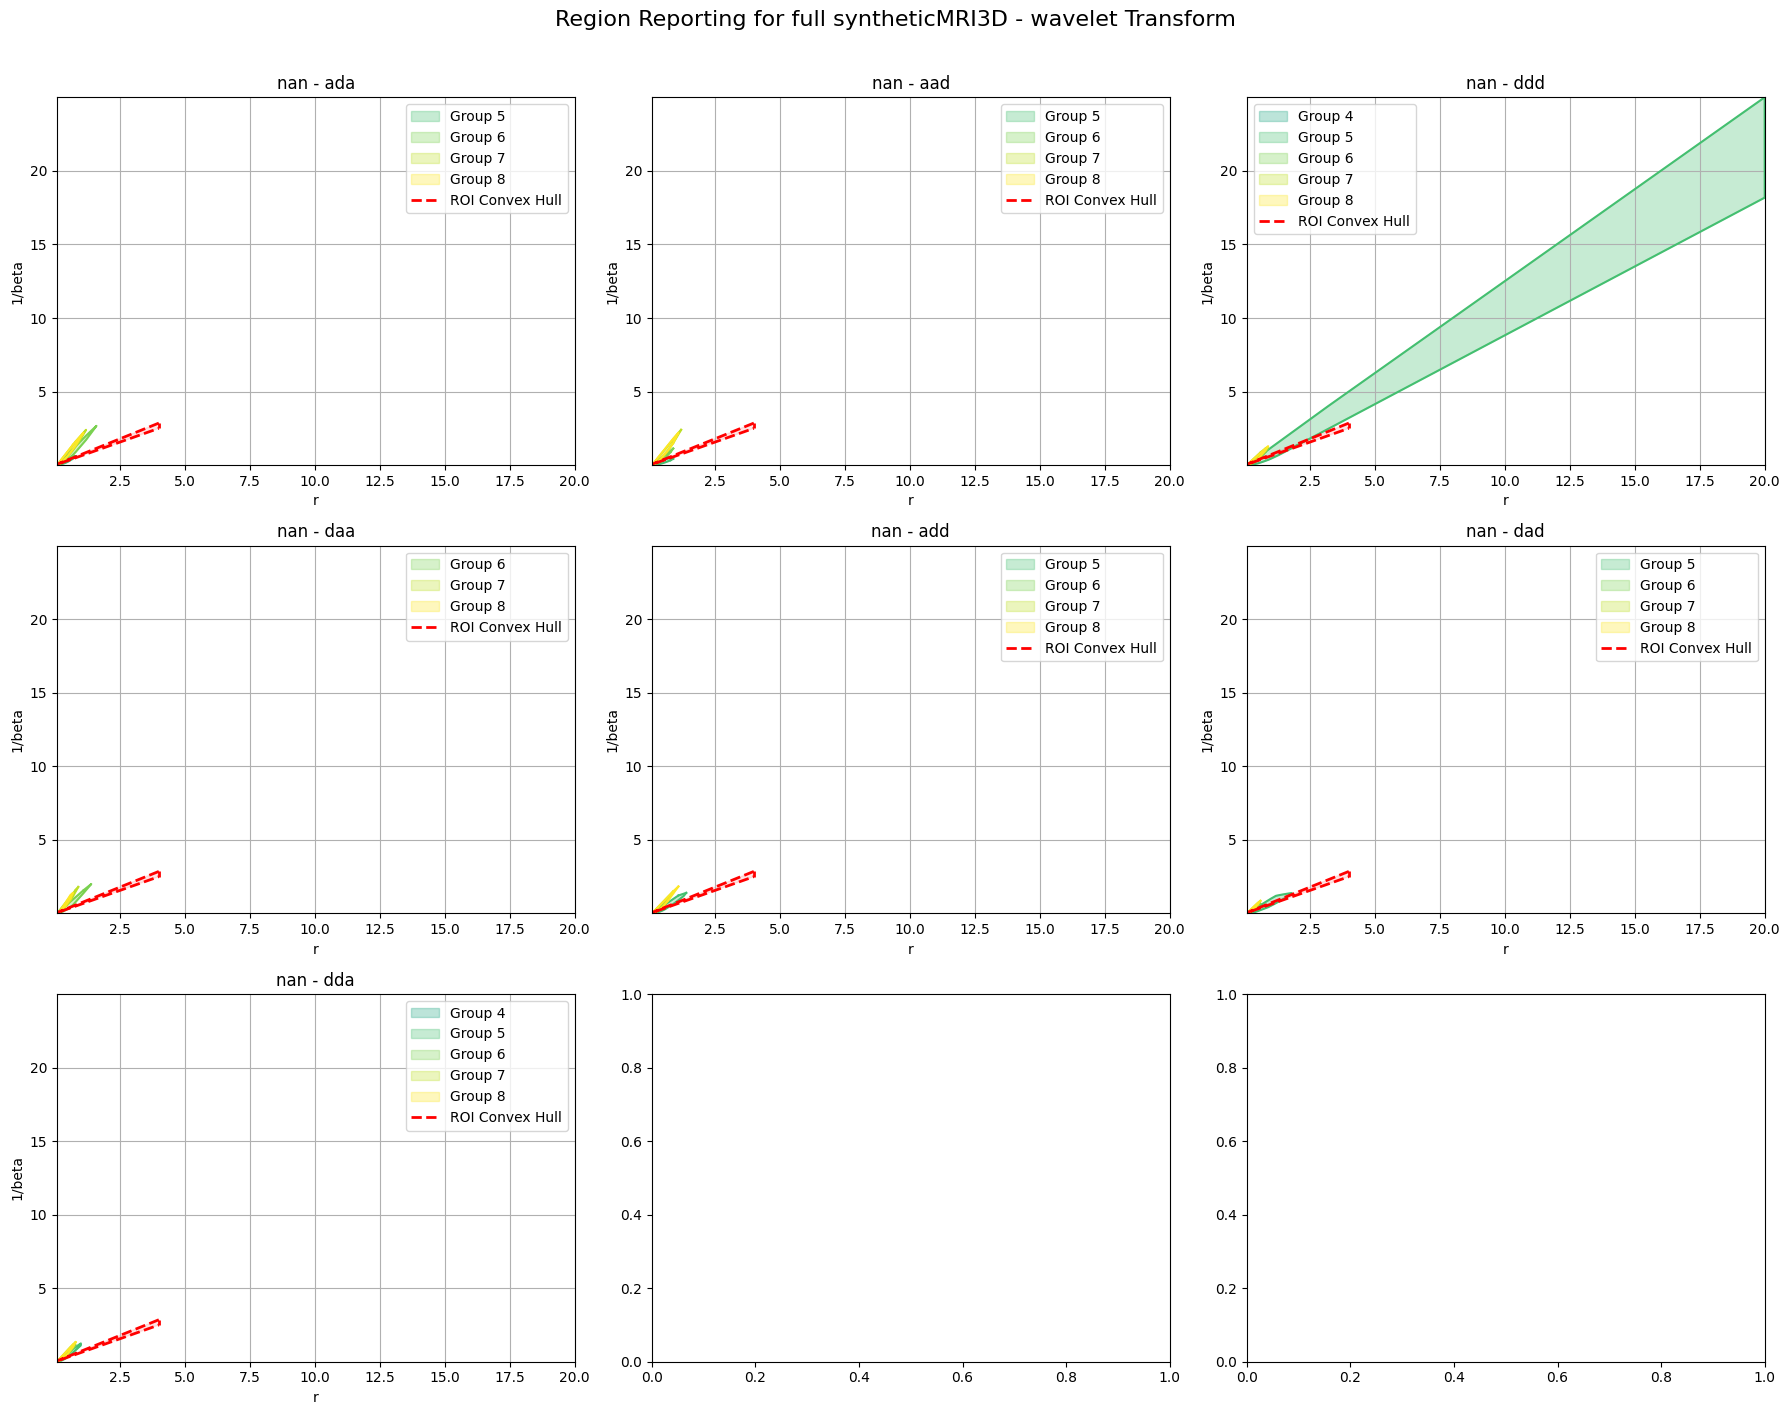

In [131]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
all_points = np.concatenate([np.array(hull.points[hull.vertices]) for hull in temp_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
if ZOOM:
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
channels = temp_df["channel"].unique()
orientations = temp_df["orientation"].unique()

if len(ORIENTATION) > 3:
    n_directions = len(ORIENTATION)
    n_rows = 3
    n_cols = math.ceil(n_directions / n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)
else:
    fig, axes = plt.subplots(len(channels), len(orientations), figsize=(6 * len(orientations), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, orientation in enumerate(orientations):
        if len(ORIENTATION) > 3:
            i, j = divmod(j, n_cols)
        ax = axes[i, j]
        if orientation is np.nan:
            subset = temp_df[(temp_df["channel"] == channel)]
        elif channel is np.nan:
            subset = temp_df[(temp_df["orientation"] == orientation)]
        else:
            subset = temp_df[(temp_df["channel"] == channel) & (temp_df["orientation"] == orientation)]
        if subset.empty:
            ax.set_title(f"{channel} - {orientation}\n(No Data)")
            ax.axis('off')
            continue
        max_group = subset["group"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_group))
        for _, row in subset.iterrows():
            group = int(row['group'])
            hull = row['hull']
            hull_points = np.array(hull.points[hull.vertices])
            color = colors[group - 1]
            kind = "Group"  # or set as needed
            ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.3, label=f'{kind} {group}')
            ax.plot(hull_points[:, 0], hull_points[:, 1], color=color)
            # Close the hull
            ax.plot([hull_points[-1, 0], hull_points[0, 0]], [hull_points[-1, 1], hull_points[0, 1]], color=color)

        # Uncomment and define roi_points, roi_hull if you want to plot ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        if orientation is np.nan:
            ax.set_title(f"{channel}")
        else:
             ax.set_title(f"{channel} - {orientation}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

### Fourier

In [132]:
DATASET = "pastis"
SUBSET = "full"
TRANSFORM = "fourier"
ORIENTATION = [np.nan]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

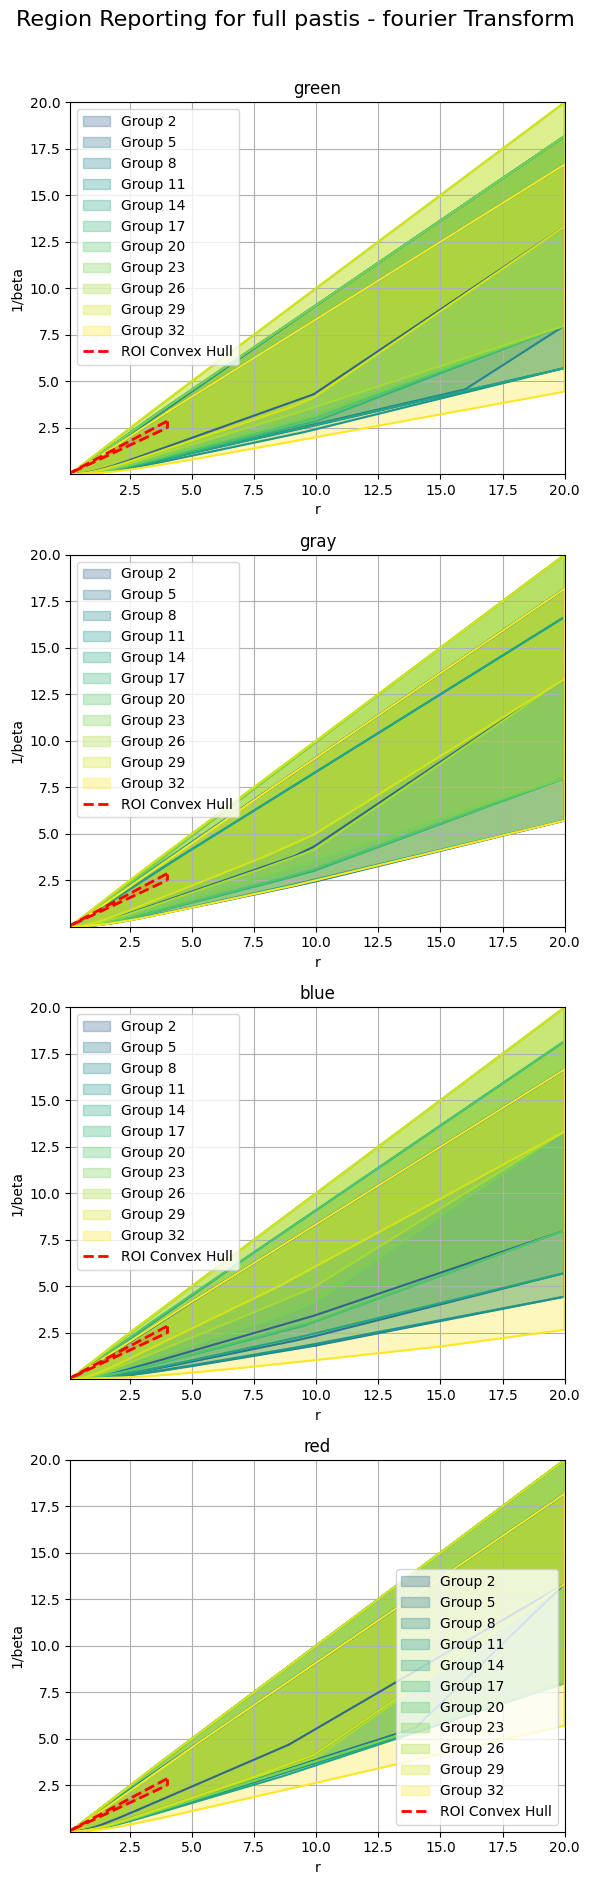

In [133]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
all_points = np.concatenate([np.array(hull.points[hull.vertices]) for hull in temp_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
if ZOOM:
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
channels = temp_df["channel"].unique()
orientations = temp_df["orientation"].unique()

if len(ORIENTATION) > 3:
    n_directions = len(ORIENTATION)
    n_rows = 3
    n_cols = math.ceil(n_directions / n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)
else:
    fig, axes = plt.subplots(len(channels), len(orientations), figsize=(6 * len(orientations), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, orientation in enumerate(orientations):
        if len(ORIENTATION) > 3:
            i, j = divmod(j, n_cols)
        ax = axes[i, j]
        if orientation is np.nan:
            subset = temp_df[(temp_df["channel"] == channel)]
        elif channel is np.nan:
            subset = temp_df[(temp_df["orientation"] == orientation)]
        else:
            subset = temp_df[(temp_df["channel"] == channel) & (temp_df["orientation"] == orientation)]
        if subset.empty:
            ax.set_title(f"{channel} - {orientation}\n(No Data)")
            ax.axis('off')
            continue
        max_group = subset["group"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_group))
        for _, row in subset.iterrows():
            group = int(row['group'])
            hull = row['hull']
            hull_points = np.array(hull.points[hull.vertices])
            color = colors[group - 1]
            kind = "Group"  # or set as needed
            ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.3, label=f'{kind} {group}')
            ax.plot(hull_points[:, 0], hull_points[:, 1], color=color)
            # Close the hull
            ax.plot([hull_points[-1, 0], hull_points[0, 0]], [hull_points[-1, 1], hull_points[0, 1]], color=color)

        # Uncomment and define roi_points, roi_hull if you want to plot ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        if orientation is np.nan:
            ax.set_title(f"{channel}")
        else:
             ax.set_title(f"{channel} - {orientation}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

## agriVision

### Wavelet

In [145]:
DATASET = "agriVision"
SUBSET = "full"
TRANSFORM = "wavelet"
ORIENTATION = ["horizvert", "diagonal"]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

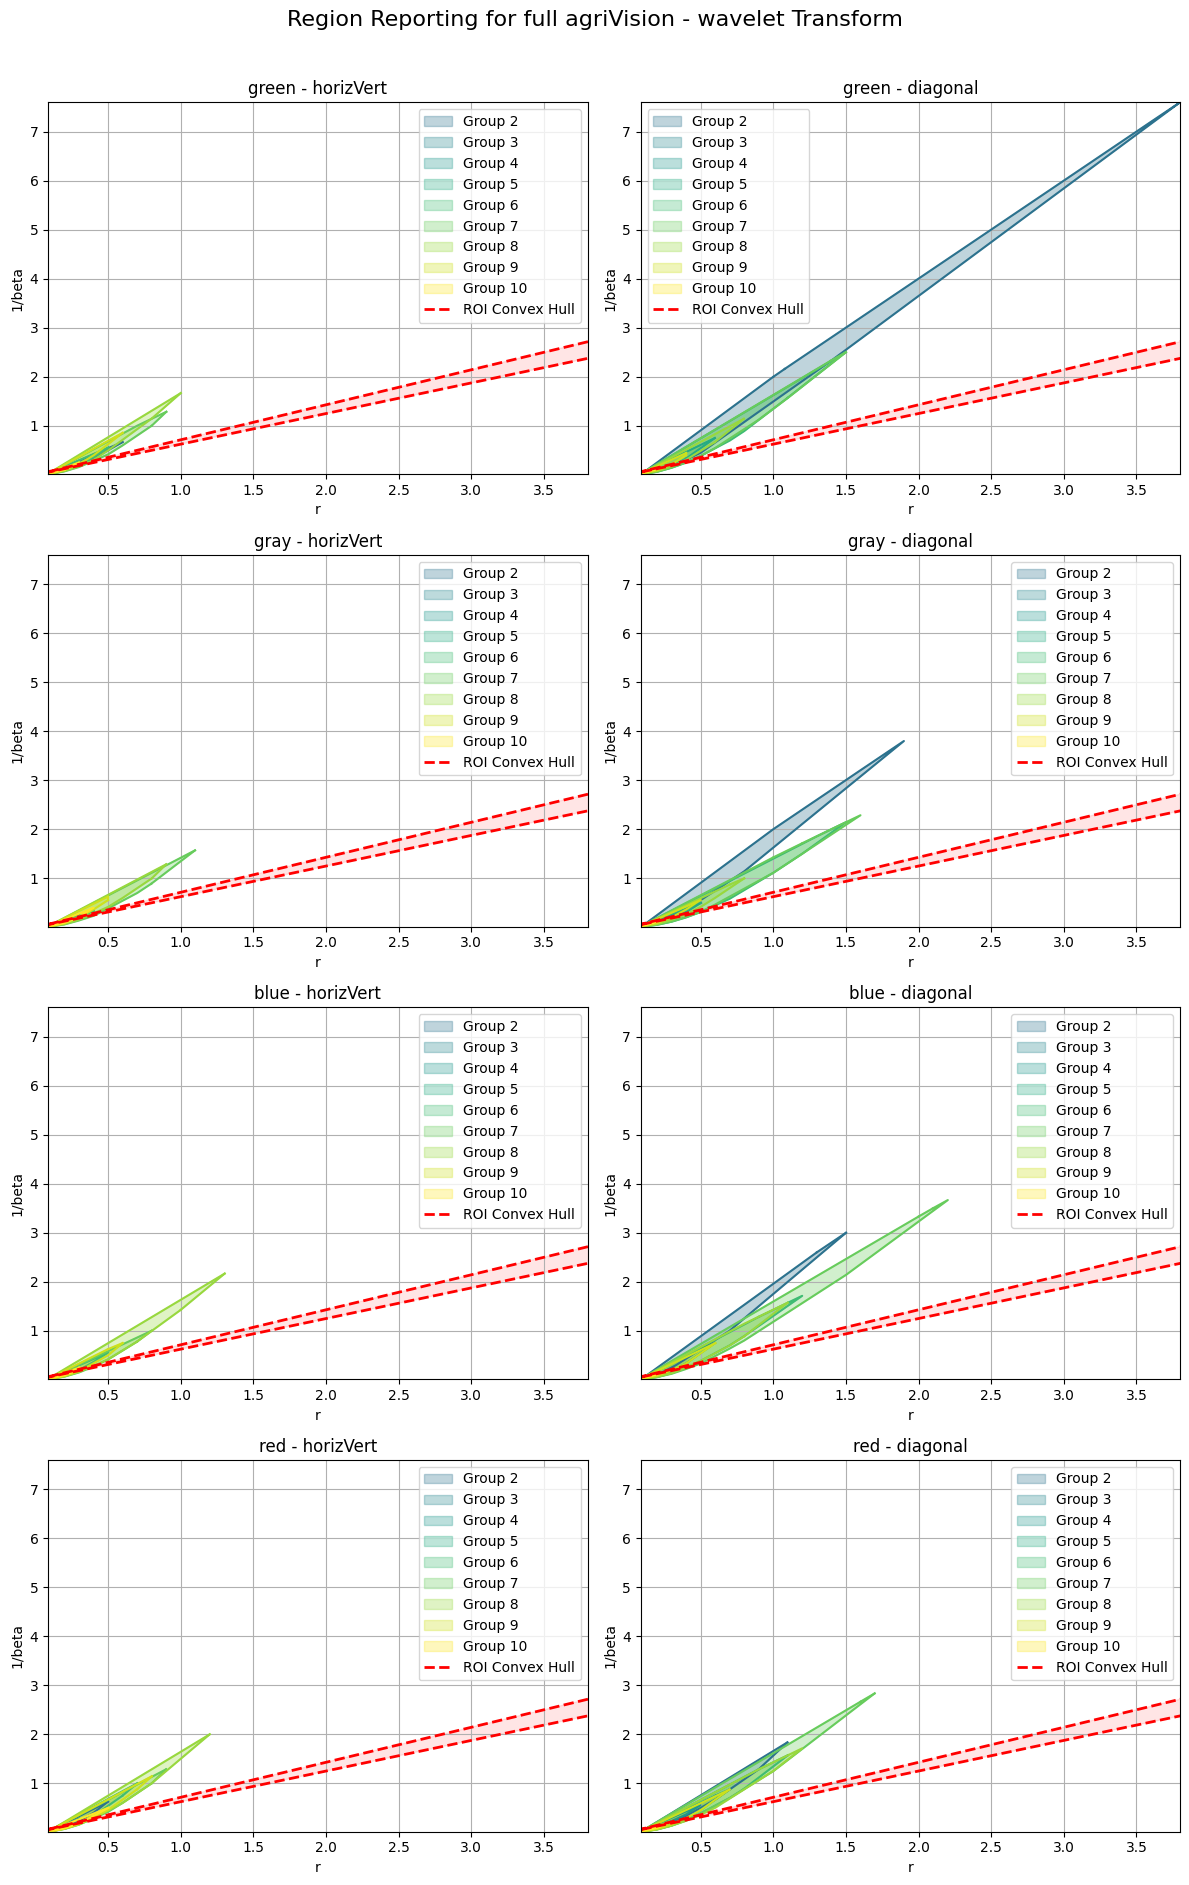

In [146]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
all_points = np.concatenate([np.array(hull.points[hull.vertices]) for hull in temp_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
if ZOOM:
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
channels = temp_df["channel"].unique()
orientations = temp_df["orientation"].unique()

if len(ORIENTATION) > 3:
    n_directions = len(ORIENTATION)
    n_rows = 3
    n_cols = math.ceil(n_directions / n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)
else:
    fig, axes = plt.subplots(len(channels), len(orientations), figsize=(6 * len(orientations), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, orientation in enumerate(orientations):
        if len(ORIENTATION) > 3:
            i, j = divmod(j, n_cols)
        ax = axes[i, j]
        if orientation is np.nan:
            subset = temp_df[(temp_df["channel"] == channel)]
        elif channel is np.nan:
            subset = temp_df[(temp_df["orientation"] == orientation)]
        else:
            subset = temp_df[(temp_df["channel"] == channel) & (temp_df["orientation"] == orientation)]
        if subset.empty:
            ax.set_title(f"{channel} - {orientation}\n(No Data)")
            ax.axis('off')
            continue
        max_group = subset["group"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_group))
        for _, row in subset.iterrows():
            group = int(row['group'])
            hull = row['hull']
            hull_points = np.array(hull.points[hull.vertices])
            color = colors[group - 1]
            kind = "Group"  # or set as needed
            ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.3, label=f'{kind} {group}')
            ax.plot(hull_points[:, 0], hull_points[:, 1], color=color)
            # Close the hull
            ax.plot([hull_points[-1, 0], hull_points[0, 0]], [hull_points[-1, 1], hull_points[0, 1]], color=color)

        # Uncomment and define roi_points, roi_hull if you want to plot ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        if orientation is np.nan:
            ax.set_title(f"{channel}")
        else:
             ax.set_title(f"{channel} - {orientation}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

### Fourier

In [147]:
DATASET = "agriVision"
SUBSET = "full"
TRANSFORM = "fourier"
ORIENTATION = [np.nan]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

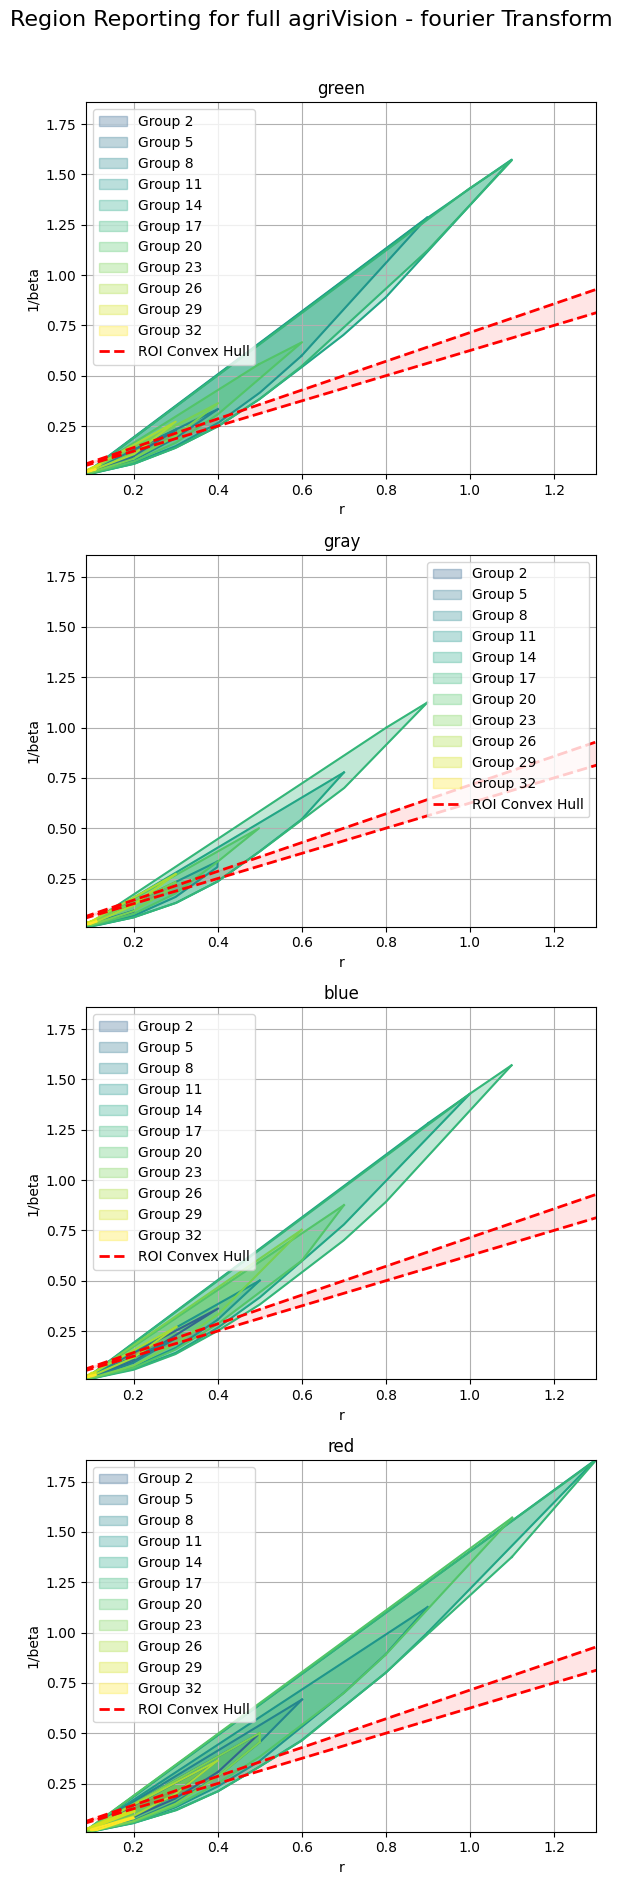

In [148]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
all_points = np.concatenate([np.array(hull.points[hull.vertices]) for hull in temp_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
if ZOOM:
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
channels = temp_df["channel"].unique()
orientations = temp_df["orientation"].unique()

if len(ORIENTATION) > 3:
    n_directions = len(ORIENTATION)
    n_rows = 3
    n_cols = math.ceil(n_directions / n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)
else:
    fig, axes = plt.subplots(len(channels), len(orientations), figsize=(6 * len(orientations), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, orientation in enumerate(orientations):
        if len(ORIENTATION) > 3:
            i, j = divmod(j, n_cols)
        ax = axes[i, j]
        if orientation is np.nan:
            subset = temp_df[(temp_df["channel"] == channel)]
        elif channel is np.nan:
            subset = temp_df[(temp_df["orientation"] == orientation)]
        else:
            subset = temp_df[(temp_df["channel"] == channel) & (temp_df["orientation"] == orientation)]
        if subset.empty:
            ax.set_title(f"{channel} - {orientation}\n(No Data)")
            ax.axis('off')
            continue
        max_group = subset["group"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_group))
        for _, row in subset.iterrows():
            group = int(row['group'])
            hull = row['hull']
            hull_points = np.array(hull.points[hull.vertices])
            color = colors[group - 1]
            kind = "Group"  # or set as needed
            ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.3, label=f'{kind} {group}')
            ax.plot(hull_points[:, 0], hull_points[:, 1], color=color)
            # Close the hull
            ax.plot([hull_points[-1, 0], hull_points[0, 0]], [hull_points[-1, 1], hull_points[0, 1]], color=color)

        # Uncomment and define roi_points, roi_hull if you want to plot ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        if orientation is np.nan:
            ax.set_title(f"{channel}")
        else:
             ax.set_title(f"{channel} - {orientation}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

## spaceNet

### Wavelet

In [149]:
DATASET = "spaceNet"
SUBSET = "full"
TRANSFORM = "wavelet"
ORIENTATION = ["horizvert", "diagonal"]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

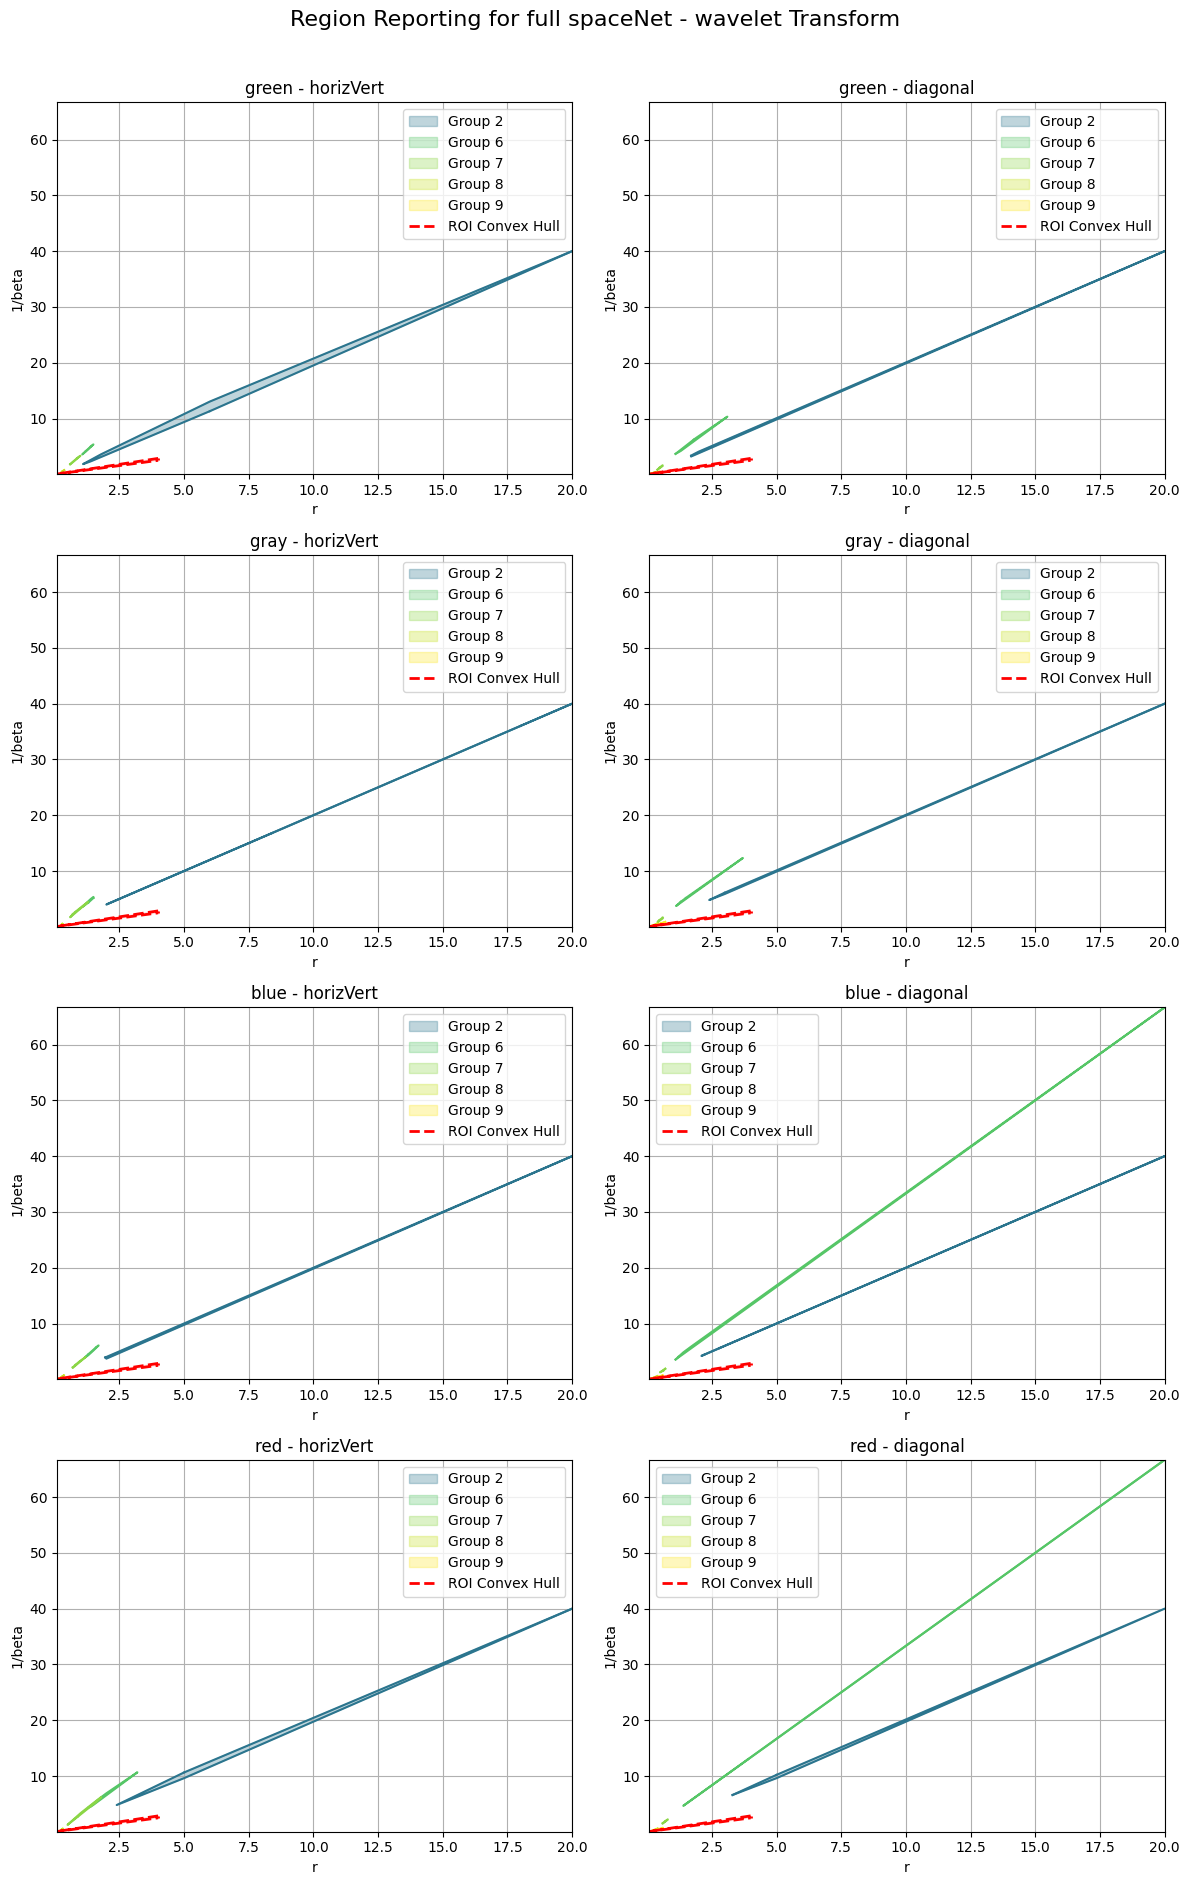

In [150]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
all_points = np.concatenate([np.array(hull.points[hull.vertices]) for hull in temp_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
if ZOOM:
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
channels = temp_df["channel"].unique()
orientations = temp_df["orientation"].unique()

if len(ORIENTATION) > 3:
    n_directions = len(ORIENTATION)
    n_rows = 3
    n_cols = math.ceil(n_directions / n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)
else:
    fig, axes = plt.subplots(len(channels), len(orientations), figsize=(6 * len(orientations), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, orientation in enumerate(orientations):
        if len(ORIENTATION) > 3:
            i, j = divmod(j, n_cols)
        ax = axes[i, j]
        if orientation is np.nan:
            subset = temp_df[(temp_df["channel"] == channel)]
        elif channel is np.nan:
            subset = temp_df[(temp_df["orientation"] == orientation)]
        else:
            subset = temp_df[(temp_df["channel"] == channel) & (temp_df["orientation"] == orientation)]
        if subset.empty:
            ax.set_title(f"{channel} - {orientation}\n(No Data)")
            ax.axis('off')
            continue
        max_group = subset["group"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_group))
        for _, row in subset.iterrows():
            group = int(row['group'])
            hull = row['hull']
            hull_points = np.array(hull.points[hull.vertices])
            color = colors[group - 1]
            kind = "Group"  # or set as needed
            ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.3, label=f'{kind} {group}')
            ax.plot(hull_points[:, 0], hull_points[:, 1], color=color)
            # Close the hull
            ax.plot([hull_points[-1, 0], hull_points[0, 0]], [hull_points[-1, 1], hull_points[0, 1]], color=color)

        # Uncomment and define roi_points, roi_hull if you want to plot ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        if orientation is np.nan:
            ax.set_title(f"{channel}")
        else:
             ax.set_title(f"{channel} - {orientation}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

### Fourier

In [151]:
DATASET = "spaceNet"
SUBSET = "full"
TRANSFORM = "fourier"
ORIENTATION = [np.nan]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

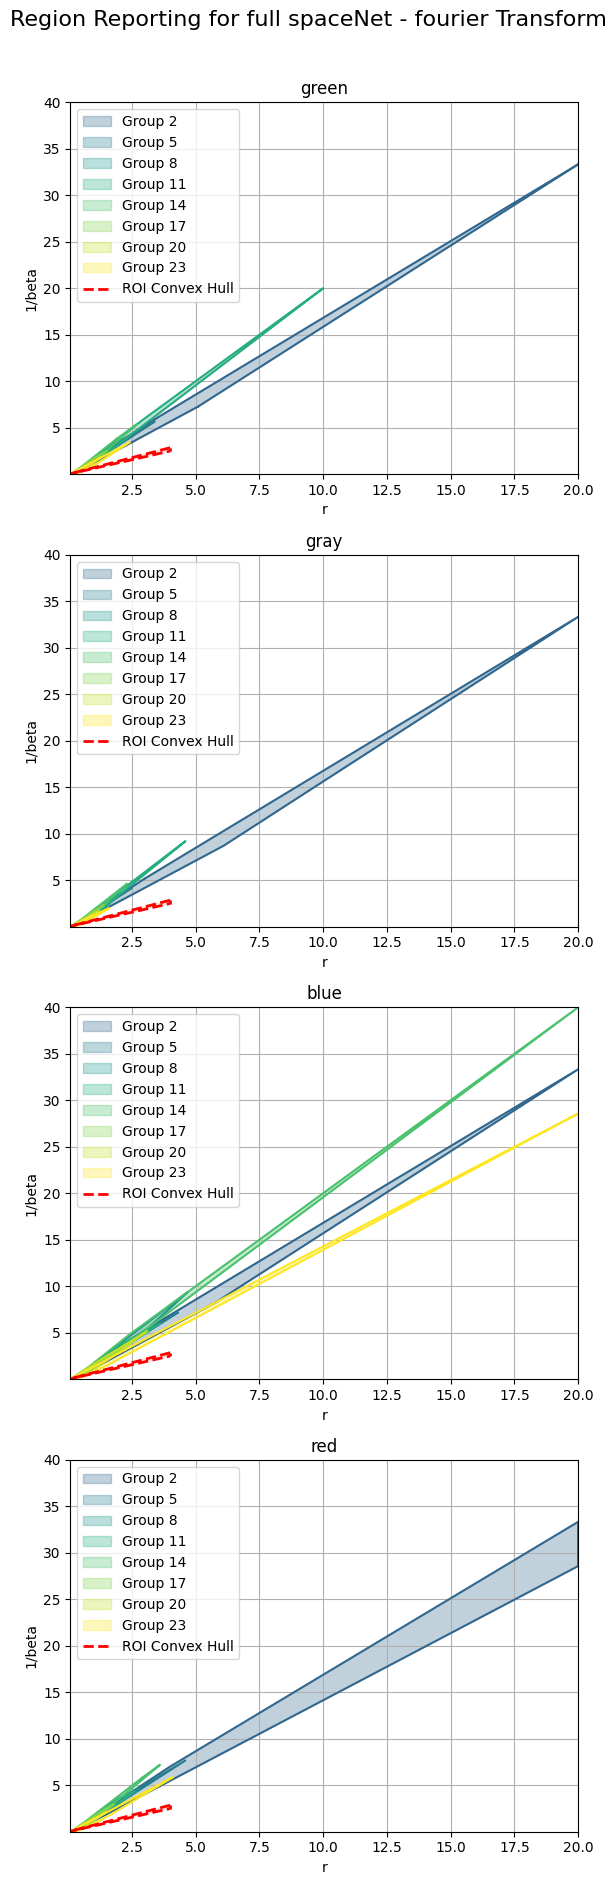

In [152]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
all_points = np.concatenate([np.array(hull.points[hull.vertices]) for hull in temp_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
if ZOOM:
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
channels = temp_df["channel"].unique()
orientations = temp_df["orientation"].unique()

if len(ORIENTATION) > 3:
    n_directions = len(ORIENTATION)
    n_rows = 3
    n_cols = math.ceil(n_directions / n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)
else:
    fig, axes = plt.subplots(len(channels), len(orientations), figsize=(6 * len(orientations), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, orientation in enumerate(orientations):
        if len(ORIENTATION) > 3:
            i, j = divmod(j, n_cols)
        ax = axes[i, j]
        if orientation is np.nan:
            subset = temp_df[(temp_df["channel"] == channel)]
        elif channel is np.nan:
            subset = temp_df[(temp_df["orientation"] == orientation)]
        else:
            subset = temp_df[(temp_df["channel"] == channel) & (temp_df["orientation"] == orientation)]
        if subset.empty:
            ax.set_title(f"{channel} - {orientation}\n(No Data)")
            ax.axis('off')
            continue
        max_group = subset["group"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_group))
        for _, row in subset.iterrows():
            group = int(row['group'])
            hull = row['hull']
            hull_points = np.array(hull.points[hull.vertices])
            color = colors[group - 1]
            kind = "Group"  # or set as needed
            ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.3, label=f'{kind} {group}')
            ax.plot(hull_points[:, 0], hull_points[:, 1], color=color)
            # Close the hull
            ax.plot([hull_points[-1, 0], hull_points[0, 0]], [hull_points[-1, 1], hull_points[0, 1]], color=color)

        # Uncomment and define roi_points, roi_hull if you want to plot ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        if orientation is np.nan:
            ax.set_title(f"{channel}")
        else:
             ax.set_title(f"{channel} - {orientation}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

# Natural Images

## coco

### Indoor

In [139]:
DATASET = "coco"
SUBSET = "indoor"
TRANSFORM = "wavelet"
ORIENTATION = ["horizontal", "vertical", "diagonal"]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

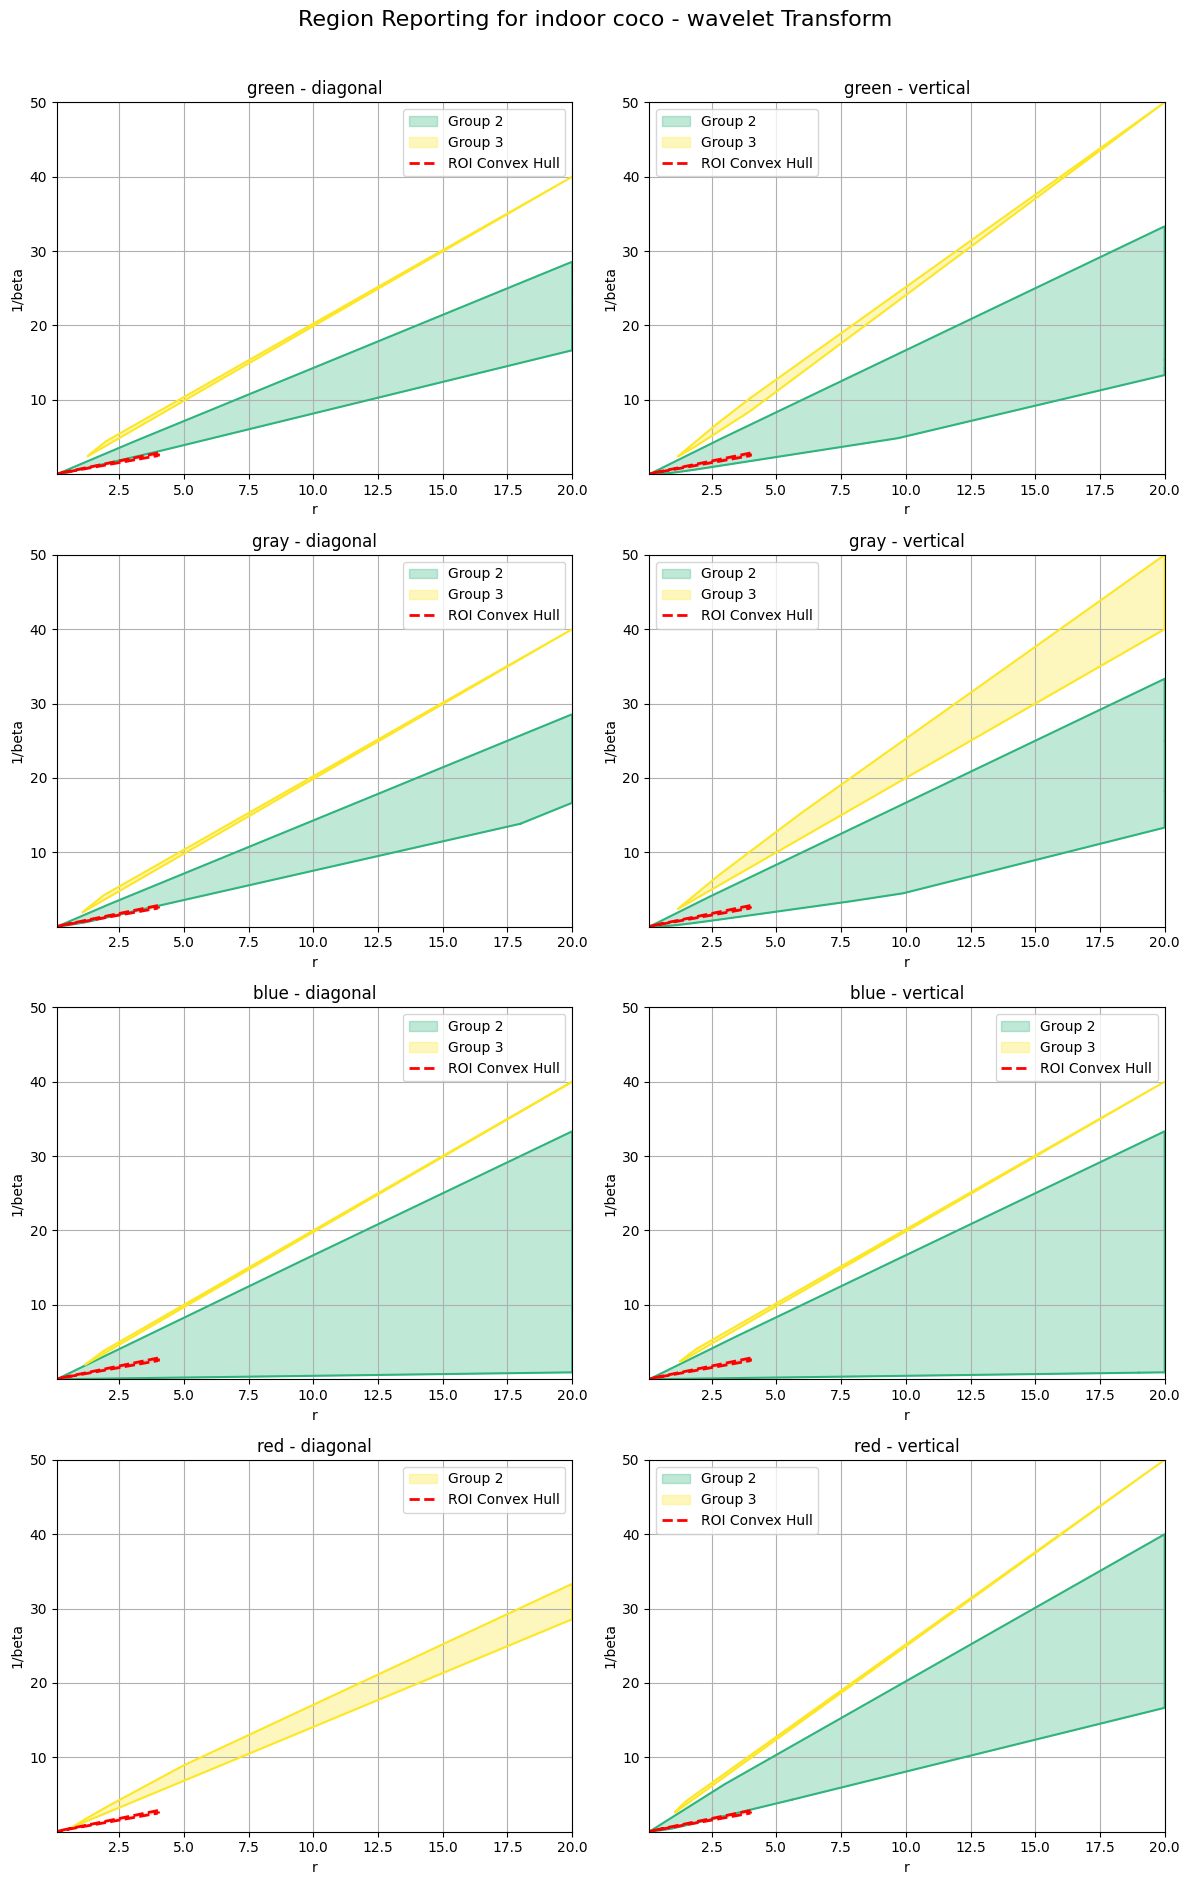

In [140]:

if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
all_points = np.concatenate([np.array(hull.points[hull.vertices]) for hull in temp_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
if ZOOM:
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
channels = temp_df["channel"].unique()
orientations = temp_df["orientation"].unique()

if len(ORIENTATION) > 3:
    n_directions = len(ORIENTATION)
    n_rows = 3
    n_cols = math.ceil(n_directions / n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)
else:
    fig, axes = plt.subplots(len(channels), len(orientations), figsize=(6 * len(orientations), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, orientation in enumerate(orientations):
        if len(ORIENTATION) > 3:
            i, j = divmod(j, n_cols)
        ax = axes[i, j]
        if orientation is np.nan:
            subset = temp_df[(temp_df["channel"] == channel)]
        elif channel is np.nan:
            subset = temp_df[(temp_df["orientation"] == orientation)]
        else:
            subset = temp_df[(temp_df["channel"] == channel) & (temp_df["orientation"] == orientation)]
        if subset.empty:
            ax.set_title(f"{channel} - {orientation}\n(No Data)")
            ax.axis('off')
            continue
        max_group = subset["group"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_group))
        for _, row in subset.iterrows():
            group = int(row['group'])
            hull = row['hull']
            hull_points = np.array(hull.points[hull.vertices])
            color = colors[group - 1]
            kind = "Group"  # or set as needed
            ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.3, label=f'{kind} {group}')
            ax.plot(hull_points[:, 0], hull_points[:, 1], color=color)
            # Close the hull
            ax.plot([hull_points[-1, 0], hull_points[0, 0]], [hull_points[-1, 1], hull_points[0, 1]], color=color)

        # Uncomment and define roi_points, roi_hull if you want to plot ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        if orientation is np.nan:
            ax.set_title(f"{channel}")
        else:
             ax.set_title(f"{channel} - {orientation}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

### Outdoor

In [141]:
DATASET = "coco"
SUBSET = "outdoor"
TRANSFORM = "wavelet"
ORIENTATION = ["horizontal", "vertical", "diagonal"]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

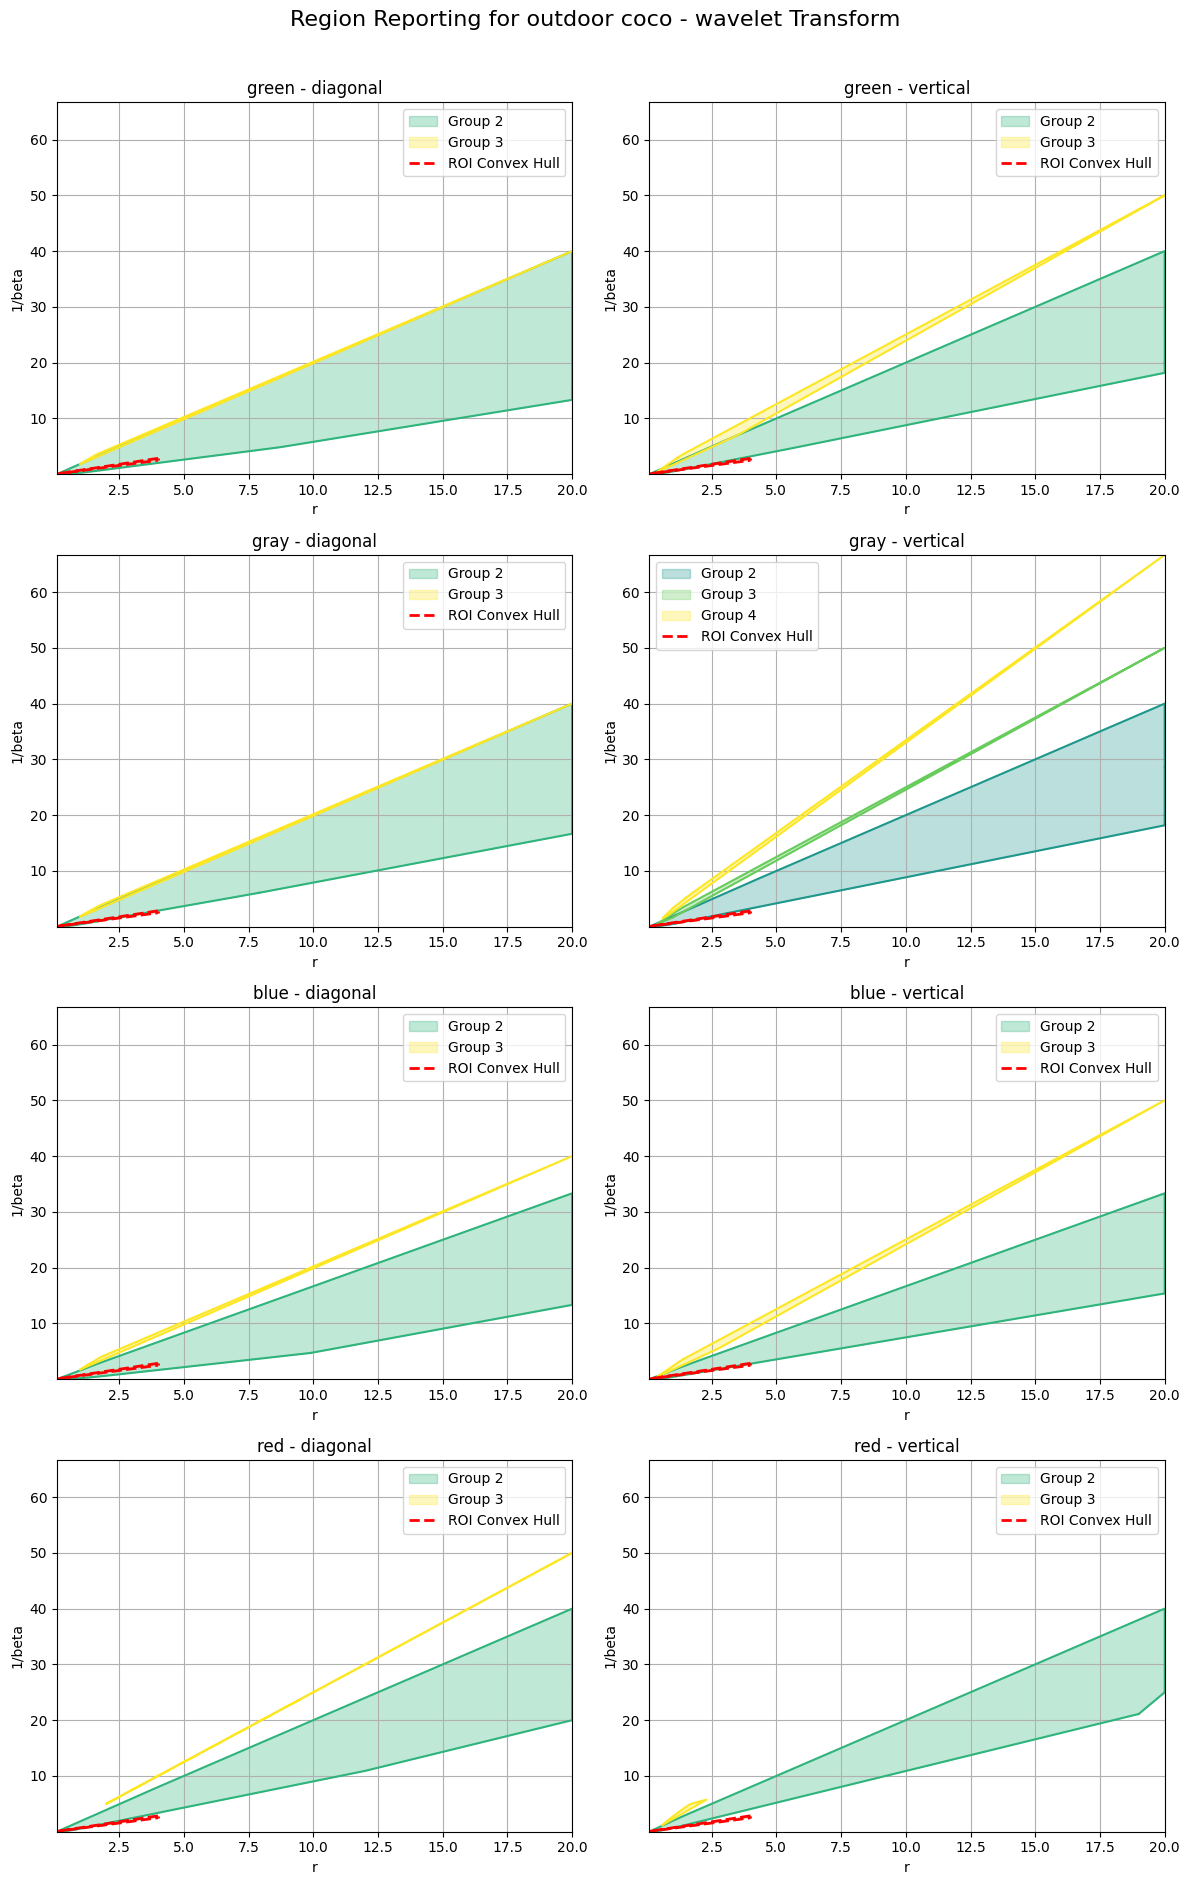

In [142]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
all_points = np.concatenate([np.array(hull.points[hull.vertices]) for hull in temp_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
if ZOOM:
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
channels = temp_df["channel"].unique()
orientations = temp_df["orientation"].unique()

if len(ORIENTATION) > 3:
    n_directions = len(ORIENTATION)
    n_rows = 3
    n_cols = math.ceil(n_directions / n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)
else:
    fig, axes = plt.subplots(len(channels), len(orientations), figsize=(6 * len(orientations), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, orientation in enumerate(orientations):
        if len(ORIENTATION) > 3:
            i, j = divmod(j, n_cols)
        ax = axes[i, j]
        if orientation is np.nan:
            subset = temp_df[(temp_df["channel"] == channel)]
        elif channel is np.nan:
            subset = temp_df[(temp_df["orientation"] == orientation)]
        else:
            subset = temp_df[(temp_df["channel"] == channel) & (temp_df["orientation"] == orientation)]
        if subset.empty:
            ax.set_title(f"{channel} - {orientation}\n(No Data)")
            ax.axis('off')
            continue
        max_group = subset["group"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_group))
        for _, row in subset.iterrows():
            group = int(row['group'])
            hull = row['hull']
            hull_points = np.array(hull.points[hull.vertices])
            color = colors[group - 1]
            kind = "Group"  # or set as needed
            ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.3, label=f'{kind} {group}')
            ax.plot(hull_points[:, 0], hull_points[:, 1], color=color)
            # Close the hull
            ax.plot([hull_points[-1, 0], hull_points[0, 0]], [hull_points[-1, 1], hull_points[0, 1]], color=color)

        # Uncomment and define roi_points, roi_hull if you want to plot ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        if orientation is np.nan:
            ax.set_title(f"{channel}")
        else:
             ax.set_title(f"{channel} - {orientation}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

## segmentAnything

In [143]:
DATASET = "segmentAnything"
SUBSET = "full"
TRANSFORM = "wavelet"
ORIENTATION = ["horizontal", "vertical", "diagonal"]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

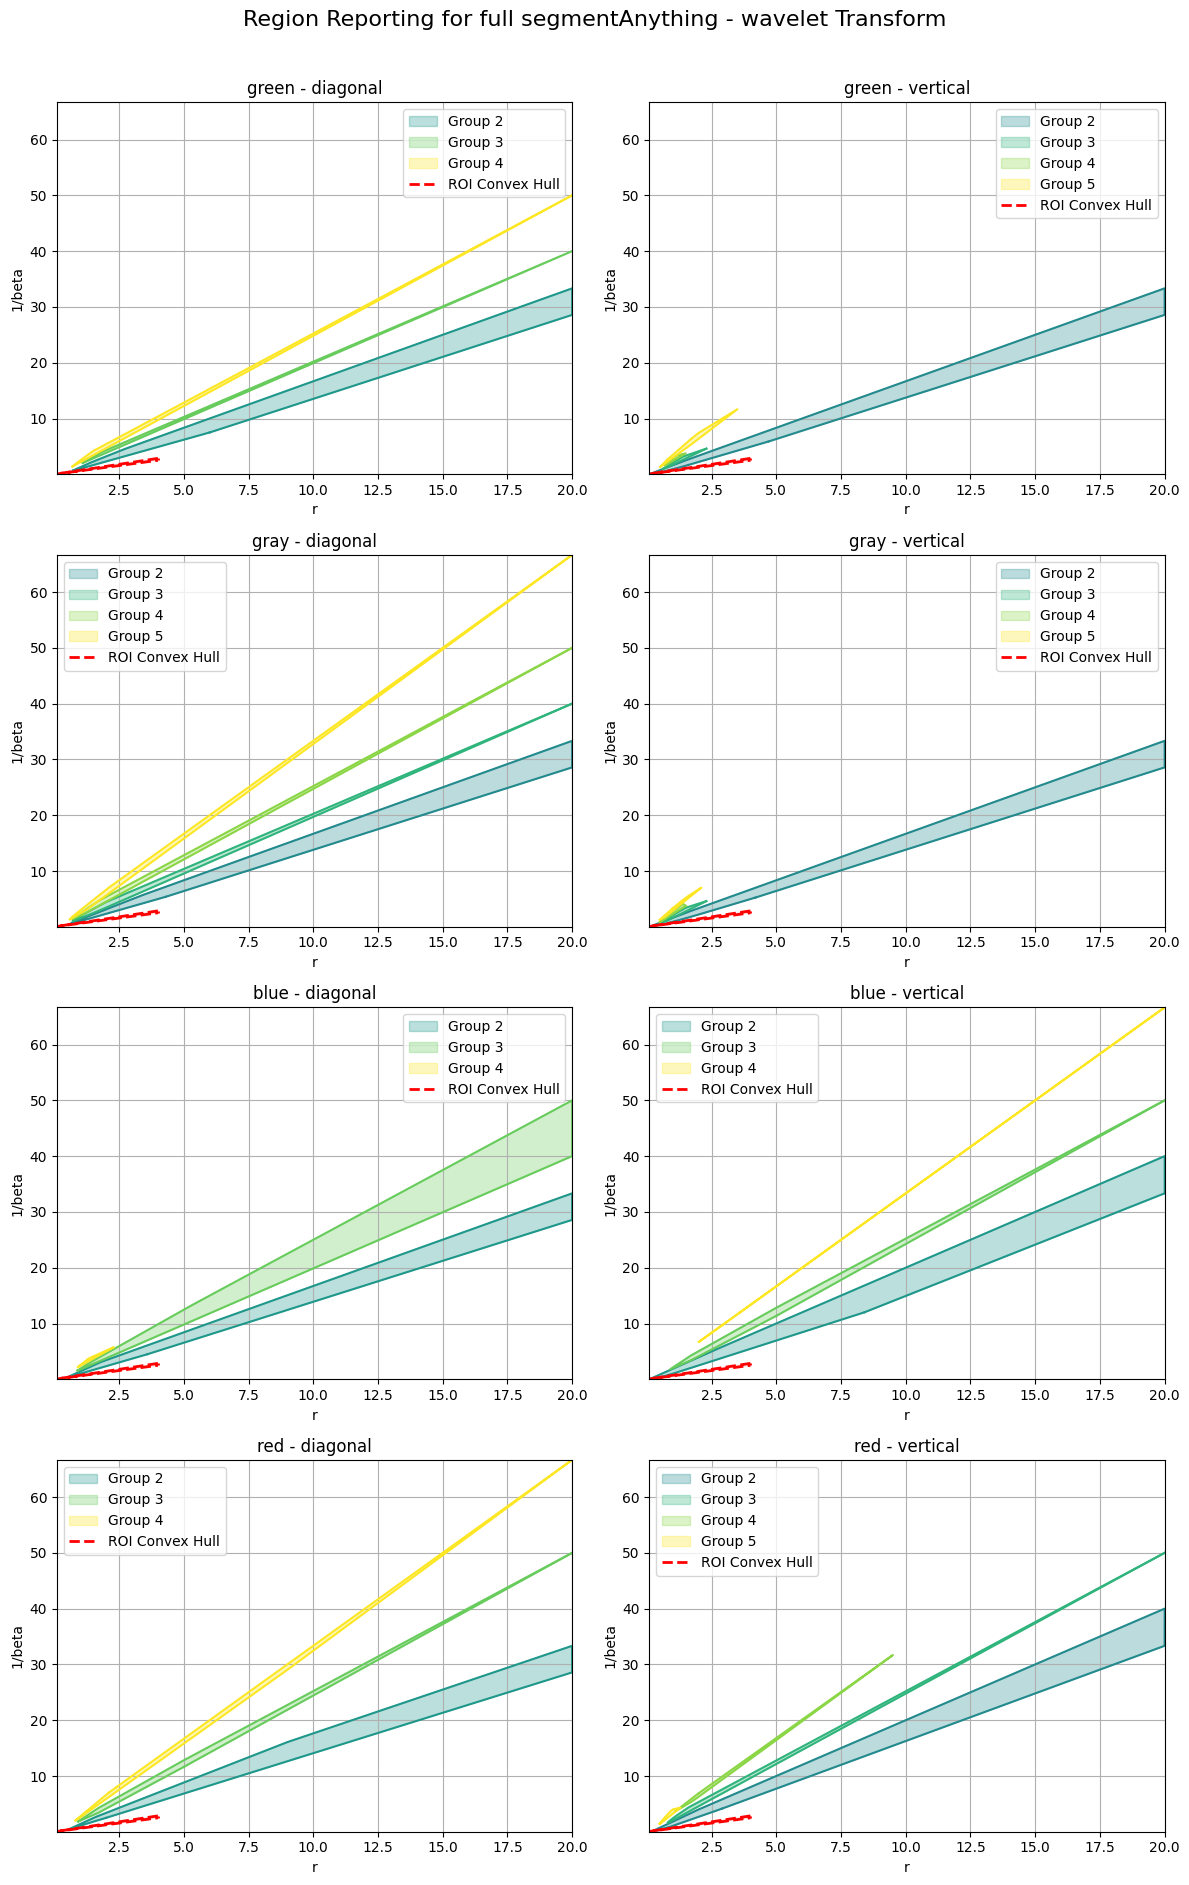

In [144]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
all_points = np.concatenate([np.array(hull.points[hull.vertices]) for hull in temp_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
if ZOOM:
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
channels = temp_df["channel"].unique()
orientations = temp_df["orientation"].unique()

if len(ORIENTATION) > 3:
    n_directions = len(ORIENTATION)
    n_rows = 3
    n_cols = math.ceil(n_directions / n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)
else:
    fig, axes = plt.subplots(len(channels), len(orientations), figsize=(6 * len(orientations), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, orientation in enumerate(orientations):
        if len(ORIENTATION) > 3:
            i, j = divmod(j, n_cols)
        ax = axes[i, j]
        if orientation is np.nan:
            subset = temp_df[(temp_df["channel"] == channel)]
        elif channel is np.nan:
            subset = temp_df[(temp_df["orientation"] == orientation)]
        else:
            subset = temp_df[(temp_df["channel"] == channel) & (temp_df["orientation"] == orientation)]
        if subset.empty:
            ax.set_title(f"{channel} - {orientation}\n(No Data)")
            ax.axis('off')
            continue
        max_group = subset["group"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_group))
        for _, row in subset.iterrows():
            group = int(row['group'])
            hull = row['hull']
            hull_points = np.array(hull.points[hull.vertices])
            color = colors[group - 1]
            kind = "Group"  # or set as needed
            ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.3, label=f'{kind} {group}')
            ax.plot(hull_points[:, 0], hull_points[:, 1], color=color)
            # Close the hull
            ax.plot([hull_points[-1, 0], hull_points[0, 0]], [hull_points[-1, 1], hull_points[0, 1]], color=color)

        # Uncomment and define roi_points, roi_hull if you want to plot ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        if orientation is np.nan:
            ax.set_title(f"{channel}")
        else:
             ax.set_title(f"{channel} - {orientation}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

# MRI

## syntheticMRI2D

In [134]:
DATASET = "syntheticMRI2D"
TYPE = "MRI"
SUBSET = ""
TRANSFORM = "wavelet"
ORIENTATION = ["horizontal", "diagonal", "vertical"]
CHANNEL = ["coronal", "axial", "sagittal"]
ZOOM  = False
PASS_ONLY = True

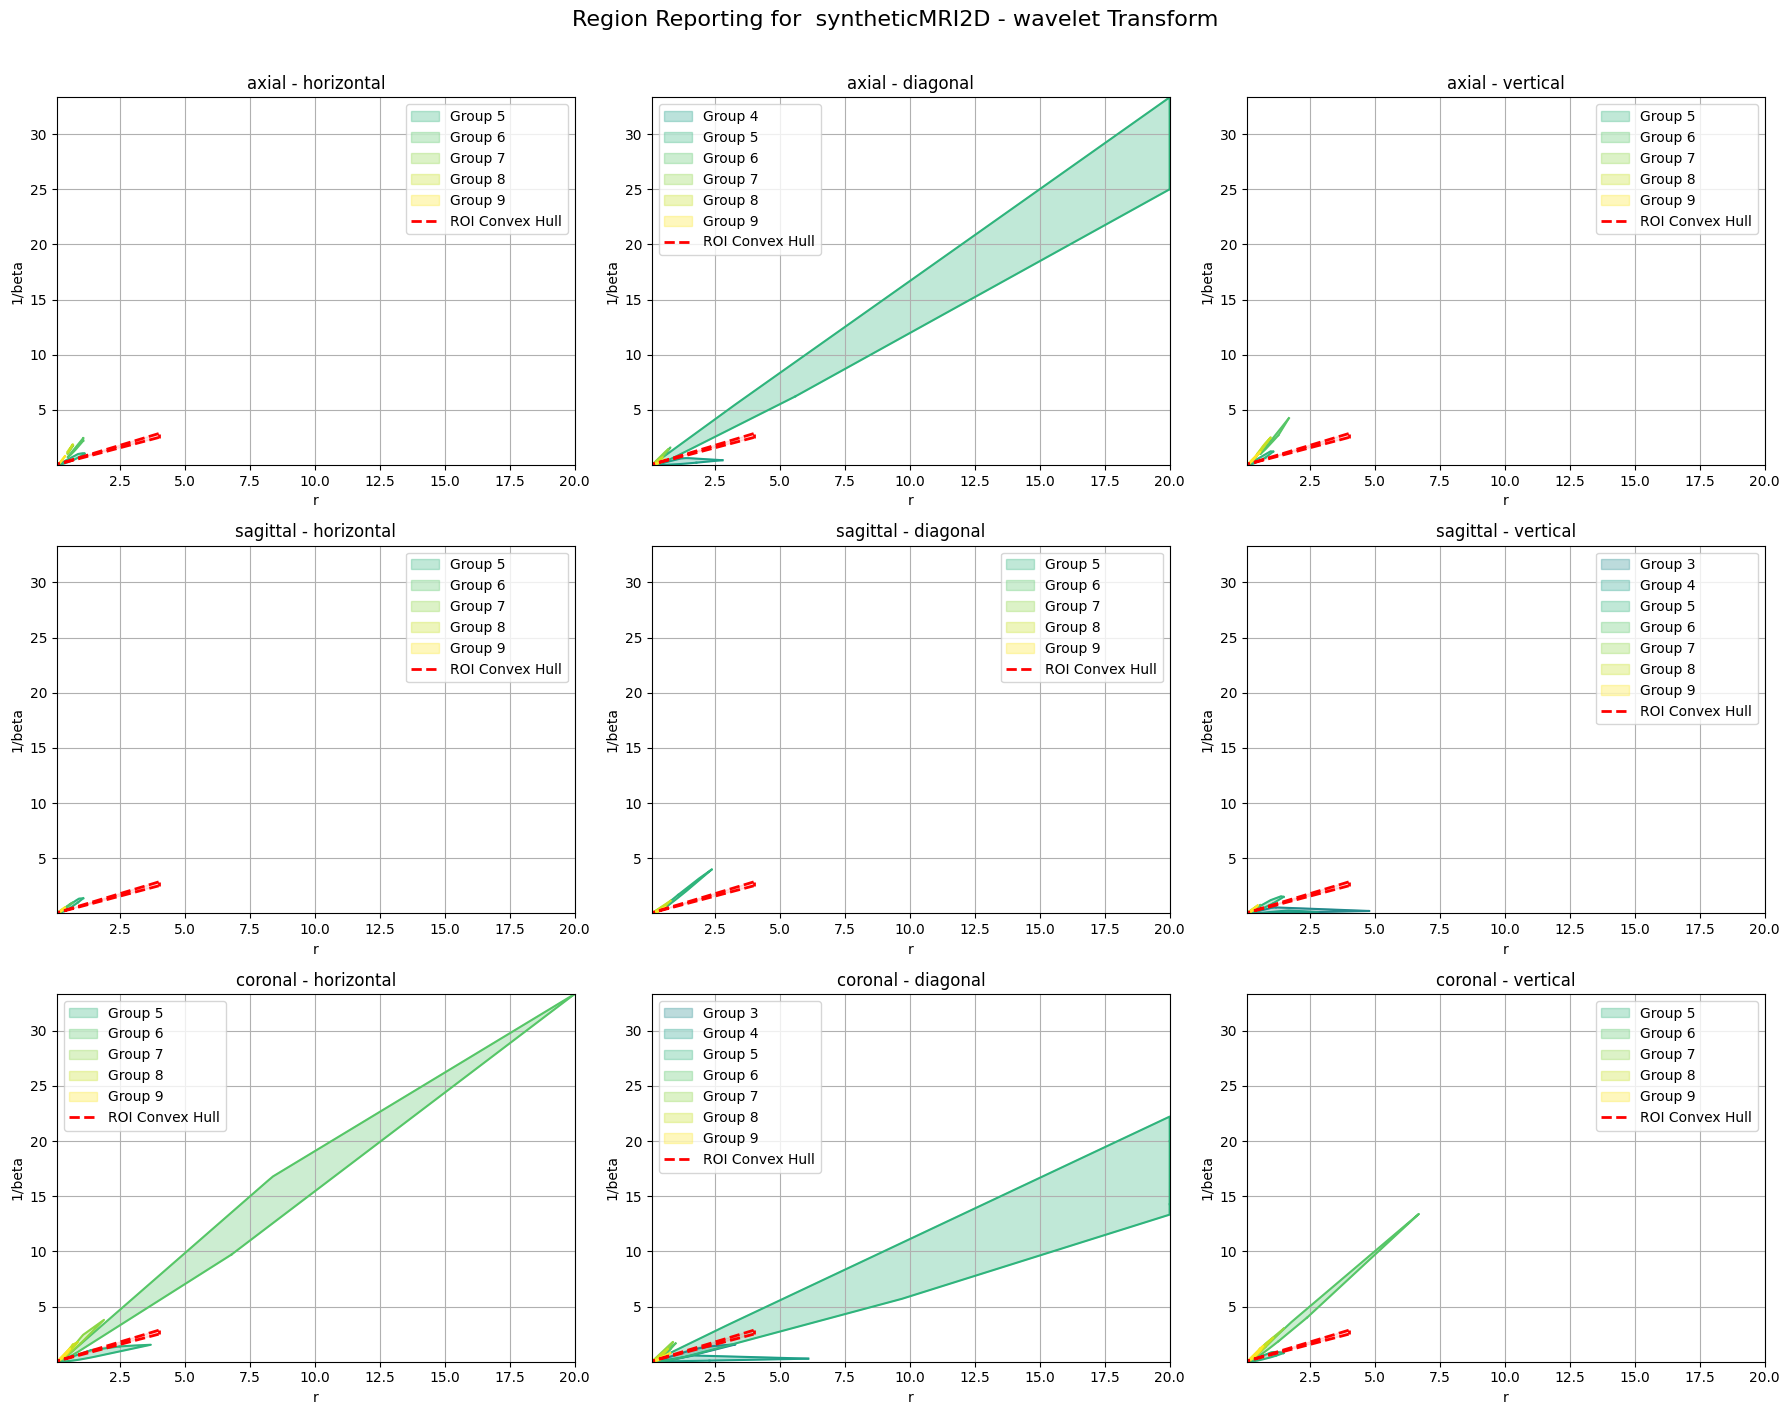

In [135]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
all_points = np.concatenate([np.array(hull.points[hull.vertices]) for hull in temp_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
if ZOOM:
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
channels = temp_df["channel"].unique()
orientations = temp_df["orientation"].unique()

if len(ORIENTATION) > 3:
    n_directions = len(ORIENTATION)
    n_rows = 3
    n_cols = math.ceil(n_directions / n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)
else:
    fig, axes = plt.subplots(len(channels), len(orientations), figsize=(6 * len(orientations), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, orientation in enumerate(orientations):
        if len(ORIENTATION) > 3:
            i, j = divmod(j, n_cols)
        ax = axes[i, j]
        if orientation is np.nan:
            subset = temp_df[(temp_df["channel"] == channel)]
        elif channel is np.nan:
            subset = temp_df[(temp_df["orientation"] == orientation)]
        else:
            subset = temp_df[(temp_df["channel"] == channel) & (temp_df["orientation"] == orientation)]
        if subset.empty:
            ax.set_title(f"{channel} - {orientation}\n(No Data)")
            ax.axis('off')
            continue
        max_group = subset["group"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_group))
        for _, row in subset.iterrows():
            group = int(row['group'])
            hull = row['hull']
            hull_points = np.array(hull.points[hull.vertices])
            color = colors[group - 1]
            kind = "Group"  # or set as needed
            ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.3, label=f'{kind} {group}')
            ax.plot(hull_points[:, 0], hull_points[:, 1], color=color)
            # Close the hull
            ax.plot([hull_points[-1, 0], hull_points[0, 0]], [hull_points[-1, 1], hull_points[0, 1]], color=color)

        # Uncomment and define roi_points, roi_hull if you want to plot ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        if orientation is np.nan:
            ax.set_title(f"{channel}")
        else:
             ax.set_title(f"{channel} - {orientation}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')

## syntheticMRI3D

In [136]:
DATASET = "syntheticMRI3D"
SUBSET = "full"
TRANSFORM = "wavelet"
ORIENTATION = ["aad", "ada", "add","daa", "dad", "dda", "ddd"]
CHANNEL = [np.nan]
ZOOM  = False
PASS_ONLY = True

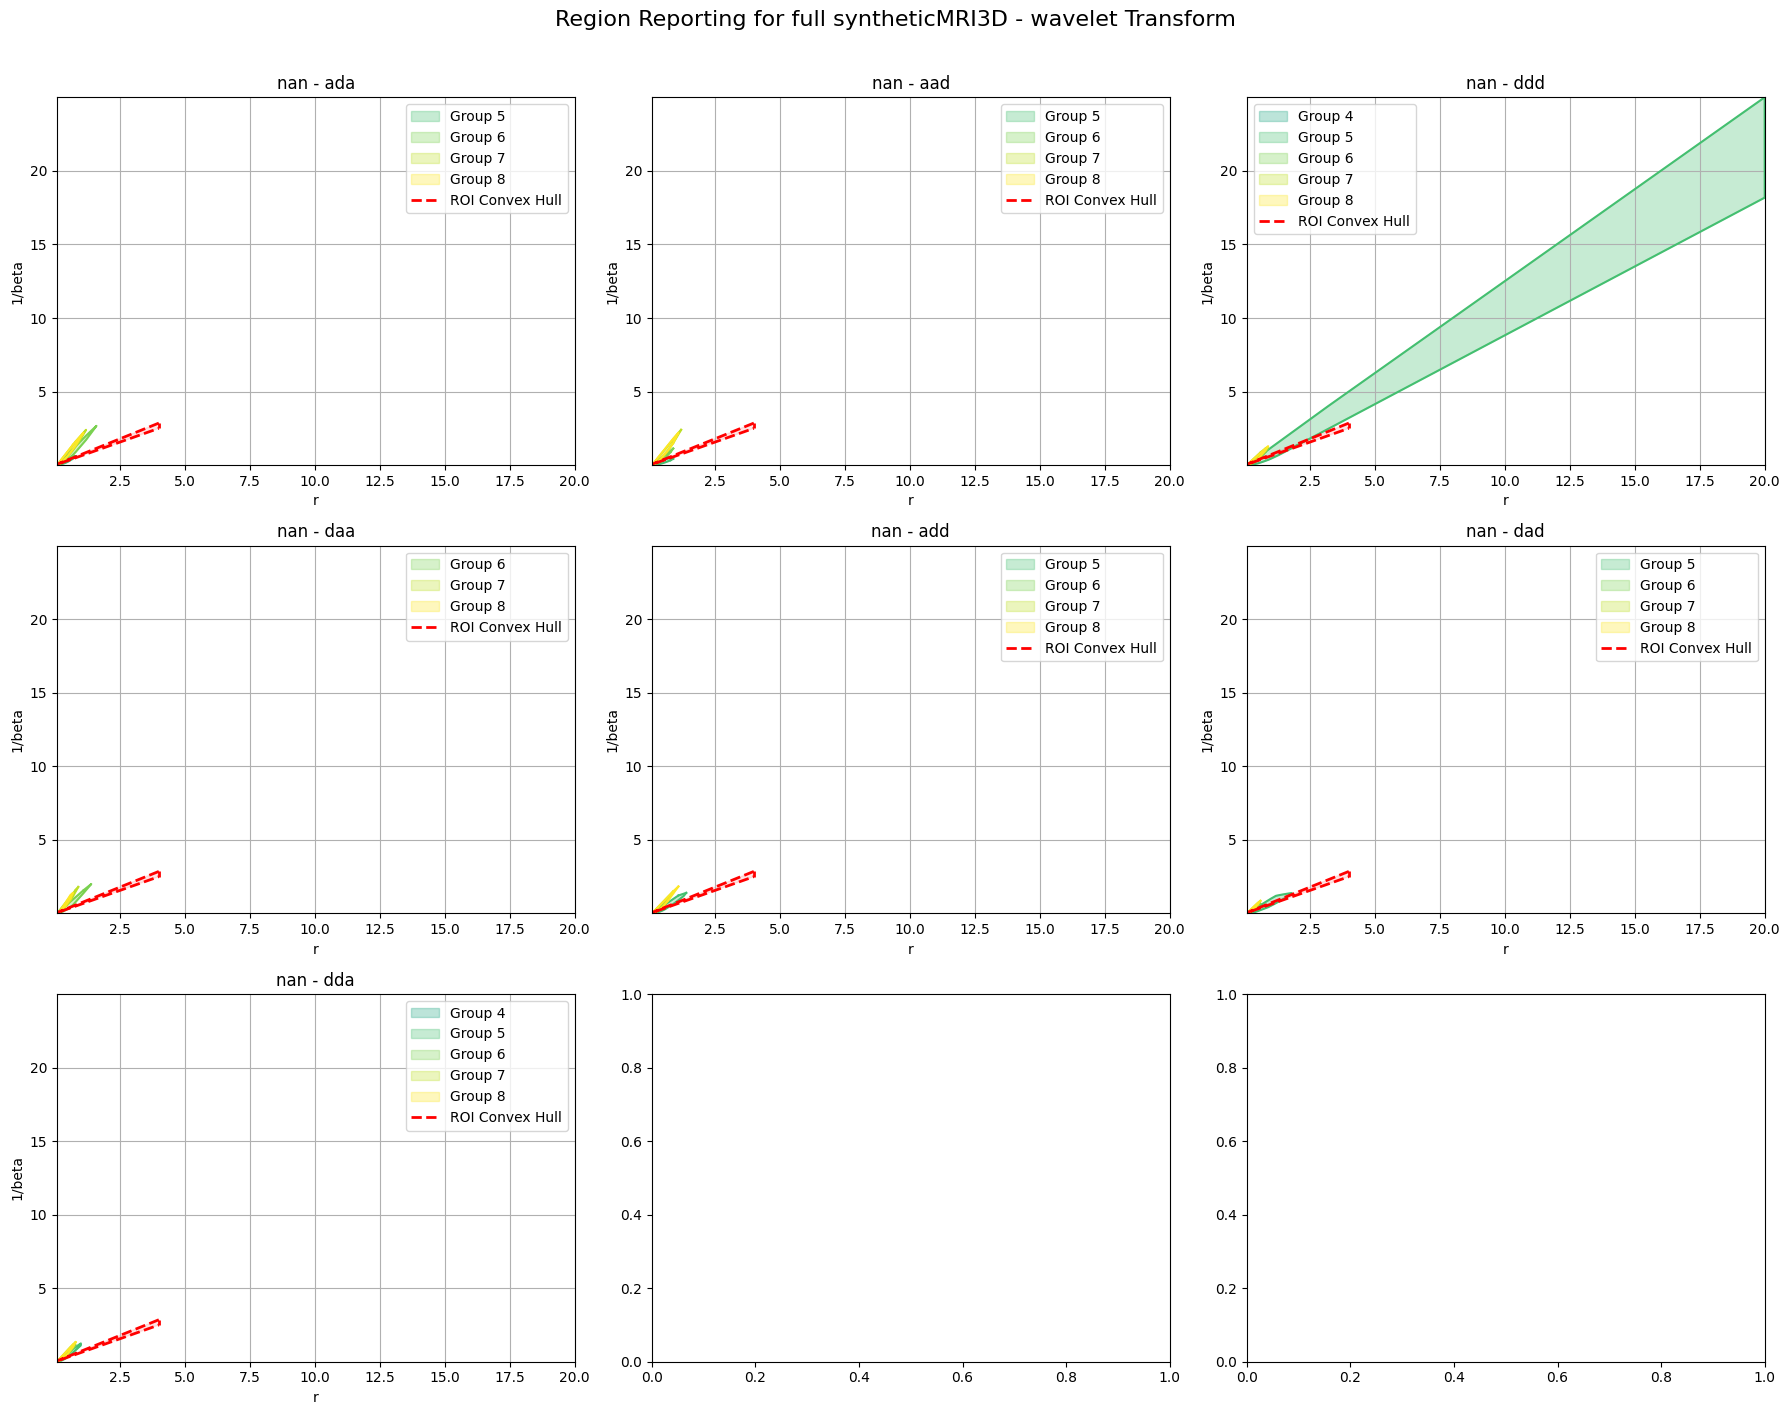

In [138]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
all_points = np.concatenate([np.array(hull.points[hull.vertices]) for hull in temp_df['hull']])
x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
if ZOOM:
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
channels = temp_df["channel"].unique()
orientations = temp_df["orientation"].unique()

if len(ORIENTATION) > 3:
    n_directions = len(ORIENTATION)
    n_rows = 3
    n_cols = math.ceil(n_directions / n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)
else:
    fig, axes = plt.subplots(len(channels), len(orientations), figsize=(6 * len(orientations), 5 * len(channels)), squeeze=False)

for i, channel in enumerate(channels):
    for j, orientation in enumerate(orientations):
        if len(ORIENTATION) > 3:
            i, j = divmod(j, n_cols)
        ax = axes[i, j]
        if orientation is np.nan:
            subset = temp_df[(temp_df["channel"] == channel)]
        elif channel is np.nan:
            subset = temp_df[(temp_df["orientation"] == orientation)]
        else:
            subset = temp_df[(temp_df["channel"] == channel) & (temp_df["orientation"] == orientation)]
        if subset.empty:
            ax.set_title(f"{channel} - {orientation}\n(No Data)")
            ax.axis('off')
            continue
        max_group = subset["group"].astype(int).max()
        colors = plt.cm.viridis(np.linspace(0.3, 1, max_group))
        for _, row in subset.iterrows():
            group = int(row['group'])
            hull = row['hull']
            hull_points = np.array(hull.points[hull.vertices])
            color = colors[group - 1]
            kind = "Group"  # or set as needed
            ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.3, label=f'{kind} {group}')
            ax.plot(hull_points[:, 0], hull_points[:, 1], color=color)
            # Close the hull
            ax.plot([hull_points[-1, 0], hull_points[0, 0]], [hull_points[-1, 1], hull_points[0, 1]], color=color)

        # Uncomment and define roi_points, roi_hull if you want to plot ROI
        ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
        ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
        ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

        if orientation is np.nan:
            ax.set_title(f"{channel}")
        else:
             ax.set_title(f"{channel} - {orientation}")
        ax.set_xlabel('r')
        ax.set_ylabel('1/beta')
        ax.legend()
        ax.grid()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

plt.suptitle(f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform", fontsize=16, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform.jpg")
    fig.savefig(save_path, dpi=600, bbox_inches='tight')